In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [14]:
#load the training datasets
ge_df = pd.read_csv("datasets/merged-combat15.csv")
bc_df = pd.read_csv("datasets/bmc15mldata1.csv")

#RFS
rfs_df = bc_df[["patient_ID", "pCR"]].dropna(axis=0, subset=["RFS"])
rfs_df.RFS = rfs_df.RFS.astype(int)
#DFS
dfs_df = bc_df[["patient_ID", "DFS"]].dropna(axis=0, subset=["DFS"])
dfs_df.DFS = dfs_df.DFS.astype(int)

def rfs_or_dfs(row):
    if row["RFS"] == 1 or row["DFS"] == 1: return 1;
    else: return 1

#dfs_or_rfs
# TODO ask Mike why the merge results in empty
outcome_df = pd.merge(rfs_df, dfs_df, on="patient_ID")

KeyError: ['RFS']

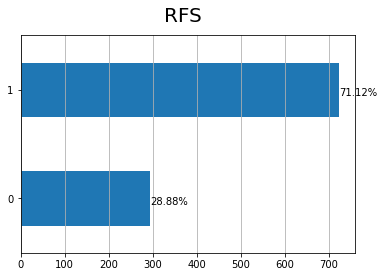

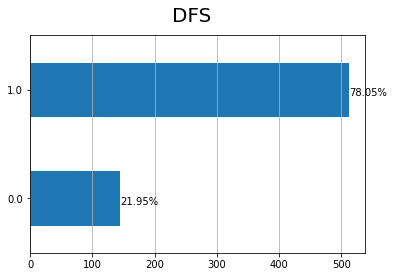

In [3]:
ge_rfs_df = pd.merge(rfs_df, ge_df, on="patient_ID")
ge_dfs_df = pd.merge(dfs_df, ge_df, on="patient_ID")

#show percentages of RFS = 1 and RFS = 2
def plot_percentages(x, y):
    totals = []
    for i in x.patches:
        totals.append(i.get_width())
    total = sum(totals)
    for i in x.patches:
         x.text(i.get_width()+.3, i.get_y()+.20,
         str(round((i.get_width()/total)*100, 2))+'%',
         fontsize=10, color='black')
    x.grid(axis="x")
    plt.suptitle(y, fontsize=20)
    plt.show()

ax1 = ge_rfs_df["RFS"].value_counts().sort_values().plot(kind="barh")


plot_percentages(ax1, "RFS")

ax2 = ge_dfs_df["DFS"].value_counts().sort_values().plot(kind="barh")
plot_percentages(ax2, "DFS")

In [18]:
#Timer used to time experiments
from scipy import stats
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time

    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

#A paramater grid for XGboost
params = {'n_estimators': [300, 400, 500, 600, 700],
              'learning_rate': [0.01, 0.03, 0.05, 0.07],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'max_depth': [3, 4, 5, 6],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'min_child_weight': [1, 2, 3, 4, 5]
  }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [15]:
#
X_rfs, y_rfs = ge_rfs_df[ge_rfs_df.columns.difference(["patient_ID", "RFS"])], ge_rfs_df["RFS"]
X_dfs, y_dfs = ge_dfs_df[ge_dfs_df.columns.difference(["patient_ID", "DFS"])], ge_dfs_df["DFS"]

In [6]:
#RFS
n_folds = 5
param_comb = 25

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4,
                                   cv=skf.split(X_rfs, y_rfs), verbose=3, random_state=42)

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_rfs, y_rfs)
timer(start_time)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[15:18:12] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:18:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 2 hours 21 minutes and 22.42 seconds.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 27.3min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 136.4min finished


In [ ]:
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
rand_search_dfs = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=8,
                                   cv=skf.split(X_dfs, y_dfs), verbose=3, random_state=42)
start_time = timer(None) # timing starts from this point for "start_time" variable
rand_search_dfs.fit(X_dfs, y_dfs)
timer(start_time)
rand_search_dfs.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [5]:
rfs_params = {'subsample': 0.8,
 'n_estimators': 400,
 'min_child_weight': 2,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 0.5,
 'colsample_bytree': 0.6}

dfs_params = {'subsample': 0.6,
 'n_estimators': 300,
 'min_child_weight': 4,
 'max_depth': 4,
 'learning_rate': 0.03,
 'gamma': 0.5,
 'colsample_bytree': 0.8}

In [6]:
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
def calc_results_simple(X, y, train_index, test_index, clf):
    X, y = X.to_numpy(), y.to_numpy(dtype=np.int64)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    y_pred  = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    acc = balanced_accuracy_score(y_test, y_pred)

    recall_0 =  recall_score(y_test, y_pred, pos_label=0)
    recall_1 =  recall_score(y_test, y_pred, pos_label=1)
    prec_0 = precision_score(y_test, y_pred, pos_label=0)
    prec_1 = precision_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_pred_prob)

    return np.array([[acc, recall_0, prec_0, recall_1, prec_1 ,auc]])

#RFS cross_validation
def run_cross_val(X, y, params, n_folds=5, random_seed=42):
    res = np.empty(shape=[0, 6])
    clf = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        res = np.append(res, calc_results_simple(X, y, train_index, test_index, clf), axis=0)
    return res, clf

In [7]:
rfs_scores, clf_rfs = run_cross_val(X_rfs, y_rfs, rfs_params)
rfs_score_df = pd.DataFrame(data=rfs_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
print(rfs_score_df.describe())

[11:16:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:16:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:17:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:17:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [16]:
dfs_scores, clf_dfs = run_cross_val(X_dfs, y_dfs, dfs_params)
dfs_score_dfs = pd.DataFrame(data=dfs_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
print(dfs_score_dfs.describe())

[11:37:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [17]:
emb_df = pd.read_csv("datasets/property_vector_pickle_2020-12-12-expanded.csv", sep="\t")
emb_rfs_df = pd.merge(rfs_df, emb_df, on="patient_ID")
emb_dfs_df = pd.merge(dfs_df, emb_df, on="patient_ID")

X_emb_rfs, y_emb_rfs = emb_rfs_df[emb_rfs_df.columns.difference(["patient_ID", "RFS"])], emb_rfs_df["RFS"]
X_emb_dfs, y_emb_dfs = emb_dfs_df[emb_dfs_df.columns.difference(["patient_ID", "DFS"])], emb_dfs_df["DFS"]

In [10]:
emb_rfs_scores, clf_emb_rfs = run_cross_val(X_emb_rfs, y_emb_rfs, rfs_params)
emb_rfs_score_df = pd.DataFrame(data=emb_rfs_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
print(emb_rfs_score_df.describe())

[11:20:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:20:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:20:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:20:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [18]:
emb_dfs_scores, clf_emb_dfs = run_cross_val(X_emb_dfs, y_emb_dfs, dfs_params)
emb_dfs_score_df = pd.DataFrame(data=emb_dfs_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
print(emb_dfs_score_df.describe())


[11:38:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:38:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:38:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:38:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [27]:
#comparison of rfs with and without the embedding
def print_score_comparison(raw_score, emb_score, target_feature="RFS",
                           header_1="Raw Score", header_2="Embedding Score"):
    print("\t\t{0}\n\t\t\t{1}\t\t{2}".format(target_feature, header_1, header_2))
    print("\t\t-----------------------------------------------")
    print("balanced_accuracy:\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["balanced_accuracy"].mean(), emb_score["balanced_accuracy"].mean()))
    print("precision_0:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["precision_0"].mean(), emb_score["precision_0"].mean()))
    print("recall_0:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["recall_0"].mean(), emb_score["recall_0"].mean()))
    print("precision_1:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["precision_1"].mean(), emb_score["precision_1"].mean()))
    print("recall_1:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["recall_1"].mean(), emb_score["recall_1"].mean()))
    print("auc:\t\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["auc"].mean(), emb_score["auc"].mean()))

print_score_comparison(rfs_score_df, emb_rfs_score_df)

		RFS
			Raw Score		Embedding Score
		-----------------------------------------------
balanced_accuracy:	61.935%			51.826%

precision_0:		69.537%			49.472%

recall_0:		29.252%			6.137%

precision_1:		76.710%			71.898%

recall_1:		94.618%			97.514%

auc:			73.982%			65.219%



In [24]:
print_score_comparison(dfs_score_dfs, emb_dfs_score_df, target_feature="DFS")

		DFS
			Raw data		Embedding
		-----------------------------------------------
balanced_accuracy:	51.432%			49.902%

precision_0:		73.333%			0.000%

recall_0:		3.448%			0.000%

precision_1:		78.550%			78.015%

recall_1:		99.416%			99.804%

auc:			66.630%			60.267%



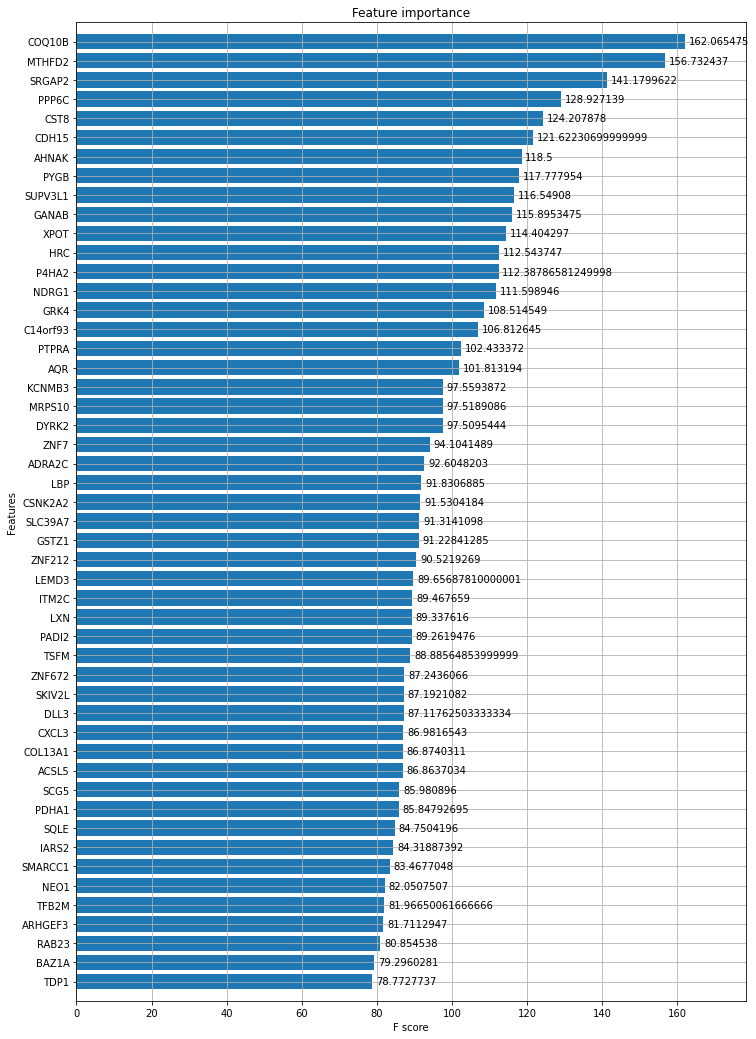

In [13]:
import xgboost as xgb
clf_rfs.get_booster().feature_names = list(X_rfs.columns.values)
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf_rfs, max_num_features=50, height=0.8, ax=ax, importance_type='cover')
plt.show()

In [91]:
feature_importance_c = clf_rfs.get_booster().get_score(importance_type='cover')
feature_importance_g= clf_rfs.get_booster().get_score(importance_type='gain')
ranked_features_c = {k: v for k, v in sorted(feature_importance_c.items(), key=lambda x: x[1], reverse=True)}
ranked_genes_c = [gene for gene in ranked_features_c]
ranked_genes_c[:50]

['COQ10B',
 'MTHFD2',
 'SRGAP2',
 'PPP6C',
 'CST8',
 'CDH15',
 'AHNAK',
 'PYGB',
 'SUPV3L1',
 'GANAB',
 'XPOT',
 'HRC',
 'P4HA2',
 'NDRG1',
 'GRK4',
 'C14orf93',
 'PTPRA',
 'AQR',
 'KCNMB3',
 'MRPS10',
 'DYRK2',
 'ZNF7',
 'ADRA2C',
 'LBP',
 'CSNK2A2',
 'SLC39A7',
 'GSTZ1',
 'ZNF212',
 'LEMD3',
 'ITM2C',
 'LXN',
 'PADI2',
 'TSFM',
 'ZNF672',
 'SKIV2L',
 'DLL3',
 'CXCL3',
 'COL13A1',
 'ACSL5',
 'SCG5',
 'PDHA1',
 'SQLE',
 'IARS2',
 'SMARCC1',
 'NEO1',
 'TFB2M',
 'ARHGEF3',
 'RAB23',
 'BAZ1A',
 'TDP1']

In [93]:
ranked_features_g = {k: v for k, v in sorted(feature_importance_g.items(), key=lambda x: x[1], reverse=True)}
tmp_dict = {}
for k, v in ranked_features_c.items():
    tmp_dict[k] = [v]

for k, v in ranked_features_g.items():
    if k in tmp_dict:
        tmp_dict[k].append(v)

combined_feature_metric = {}
for k in tmp_dict:
    combined_feature_metric[k] = tmp_dict[k][0] * tmp_dict[k][1]

combined_feature_metric = {k: v for k, v in sorted(combined_feature_metric.items(), key=lambda x: x[1], reverse=True)}
ranked_genes = [gene for gene in combined_feature_metric]
ranked_genes[:50]

['COQ10B',
 'MTHFD2',
 'SRGAP2',
 'SUPV3L1',
 'CST8',
 'PPP6C',
 'AQR',
 'C14orf93',
 'PYGB',
 'GANAB',
 'AHNAK',
 'GRK4',
 'CDH15',
 'P4HA2',
 'SLC39A7',
 'HRC',
 'PTPRA',
 'MRPS10',
 'CASP8AP2',
 'CXCL13',
 'XPOT',
 'CAPN9',
 'SMARCC1',
 'CSNK2A2',
 'KCNMB3',
 'GSTZ1',
 'ZNF7',
 'CXCL3',
 'BAZ1A',
 'ARHGEF3',
 'LBP',
 'TSFM',
 'ZNF212',
 'ZNF672',
 'NDRG1',
 'GTF2H4',
 'IARS2',
 'LXN',
 'SCG5',
 'DYRK2',
 'TDP1',
 'PTCD2',
 'PDHA1',
 'LENEP',
 'COL13A1',
 'ACSL5',
 'SLC4A8',
 'NEDD9',
 'RIN2',
 'SKIV2L']

In [20]:
#BP embedding
emb_bp_df = pd.read_csv("datasets/property_vector_pickle_bp-expanded.csv", sep="\t")
emb_bp_rfs_df = pd.merge(rfs_df, emb_bp_df, on="patient_ID")
emb_bp_dfs_df = pd.merge(dfs_df, emb_bp_df, on="patient_ID")

X_emb_bp_rfs, y_emb_bp_rfs = emb_bp_rfs_df[emb_bp_rfs_df.columns.difference(["patient_ID", "RFS"])], emb_bp_rfs_df["RFS"]
X_emb_bp_dfs, y_emb_bp_dfs = emb_bp_dfs_df[emb_bp_dfs_df.columns.difference(["patient_ID", "DFS"])], emb_bp_dfs_df["DFS"]

In [21]:
emb_bp_rfs_scores, clf_emb_bp_rfs = run_cross_val(X_emb_bp_rfs, y_emb_bp_rfs, rfs_params)
emb_bp_rfs_score_df = pd.DataFrame(data=emb_bp_rfs_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
print(emb_bp_rfs_score_df.describe())

[11:52:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [25]:
print_score_comparison(rfs_score_df, emb_bp_rfs_score_df)

		RFS
			Raw data		Embedding
		-----------------------------------------------
balanced_accuracy:	61.935%			51.755%

precision_0:		69.537%			52.278%

recall_0:		29.252%			6.131%

precision_1:		76.710%			71.869%

recall_1:		94.618%			97.378%

auc:			73.982%			64.810%



In [28]:
print_score_comparison(emb_rfs_score_df, emb_bp_rfs_score_df, header_1="Embedding all GO", header_2="Embedding BP only")


		RFS
			Embedding all GO		Embedding BP only
		-----------------------------------------------
balanced_accuracy:	51.826%			51.755%

precision_0:		49.472%			52.278%

recall_0:		6.137%			6.131%

precision_1:		71.898%			71.869%

recall_1:		97.514%			97.378%

auc:			65.219%			64.810%



In [29]:
emb_bp_dfs_scores, clf_emb_bp_dfs = run_cross_val(X_emb_bp_dfs, y_emb_bp_dfs, dfs_params)
emb_bp_dfs_score_df = pd.DataFrame(data=emb_bp_dfs_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
print(emb_bp_dfs_score_df.describe())

[12:09:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:10:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:11:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:12:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [31]:
print_score_comparison(emb_dfs_score_df, emb_bp_dfs_score_df, target_feature="DFS", header_1="Embedding all GO", header_2="Embedding BP only")

		DFS
			Embedding all GO		Embedding BP only
		-----------------------------------------------
balanced_accuracy:	49.902%			50.000%

precision_0:		0.000%			0.000%

recall_0:		0.000%			0.000%

precision_1:		78.015%			78.049%

recall_1:		99.804%			100.000%

auc:			60.267%			61.015%

